In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

test1 image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
test2 image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
test3 image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


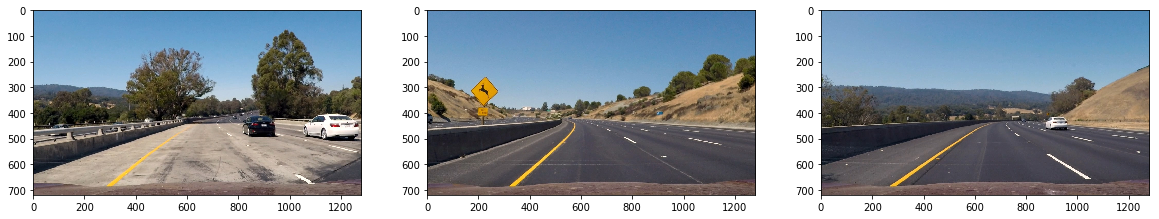

In [2]:
# show test images
fig = plt.figure(figsize=(20, 5))
image1 = mpimg.imread('./test_images/test1.jpg')
print('test1 image is:', type(image1), 'with dimesions:', image1.shape)
fig.add_subplot(1,3,1)
plt.imshow(image1) 
image2 = mpimg.imread('./test_images/test2.jpg')
print('test2 image is:', type(image1), 'with dimesions:', image2.shape)
fig.add_subplot(1,3,2)
plt.imshow(image2) 
image3 = mpimg.imread('./test_images/test3.jpg')
print('test3 image is:', type(image1), 'with dimesions:', image3.shape)
fig.add_subplot(1,3,3)
plt.imshow(image3) 

In [3]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

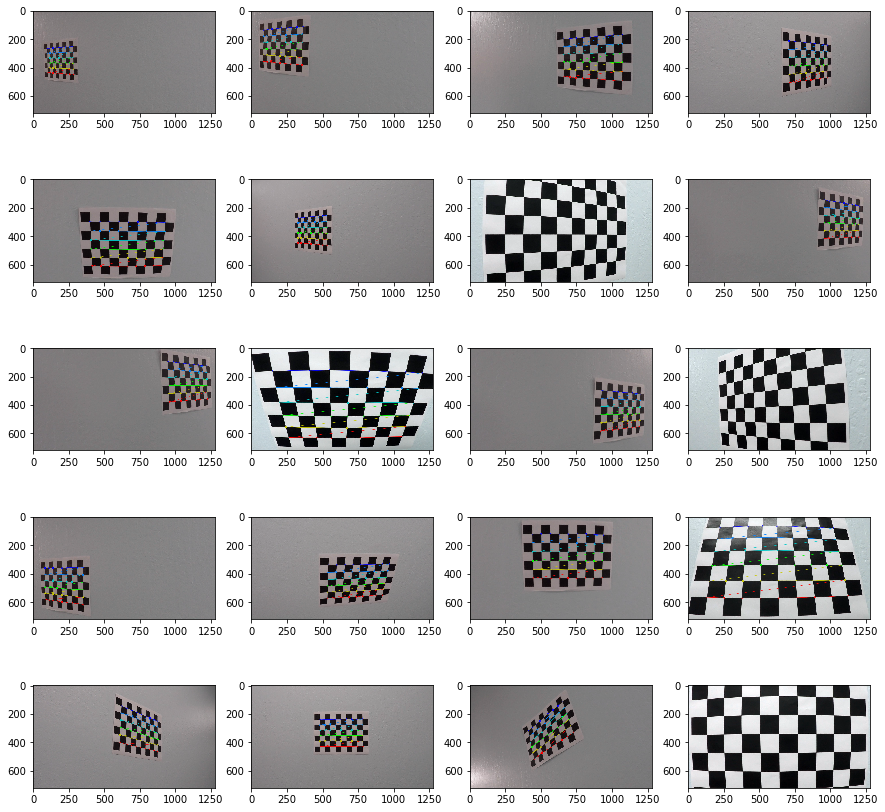

In [4]:
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig = plt.figure(figsize=(15, 15))
i = 1
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    fig.add_subplot(5,4,i)
    i += 1
    plt.imshow(img)


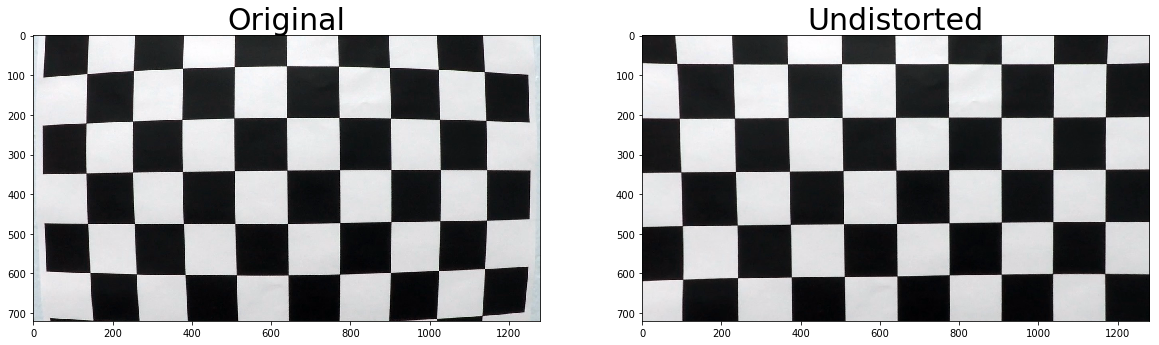

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
img = cv2.imread('./camera_cal/calibration1.jpg')

# calibration function, return undistorted image
def calibration(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    return undist

undistorted = calibration(img, objpoints, imgpoints)

# compare original and undistorted images
fig = plt.figure(figsize=(20, 15))
fig.add_subplot(1,2,1)
plt.title('Original',fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.title('Undistorted',fontsize=30)
plt.imshow(undistorted)

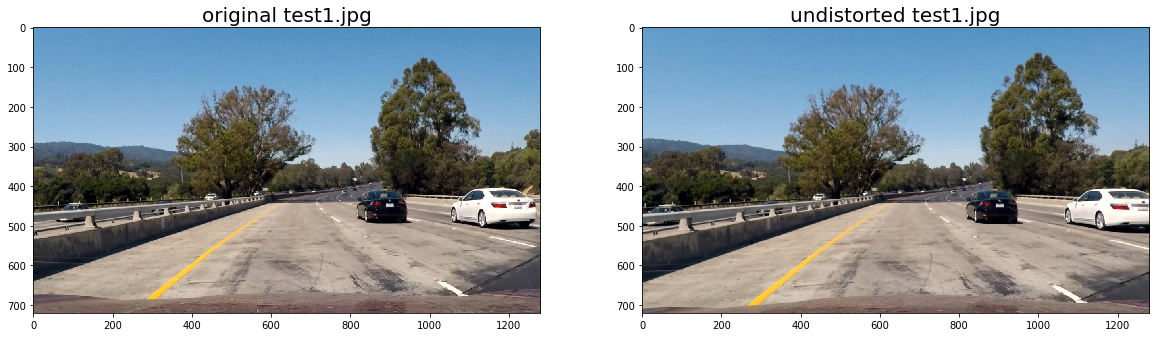

In [6]:
# test calibration funciton on test images
fig = plt.figure(figsize=(20, 15))
image = mpimg.imread('test_images/test1.jpg')
fig.add_subplot(1,2,1)
plt.title('original test1.jpg',fontsize=20)
plt.imshow(image) 
undistorted = calibration(image, objpoints, imgpoints)
fig.add_subplot(1,2,2)
plt.title('undistorted test1.jpg',fontsize=20)
plt.imshow(undistorted)

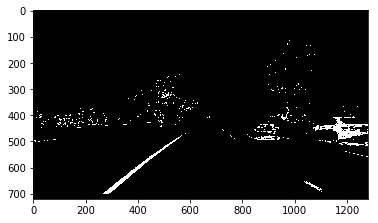

In [14]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]  
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# test hls_select with undistorted image
hls_undistorted = hls_select(undistorted, (160, 255))
plt.imshow(hls_undistorted, cmap='gray')

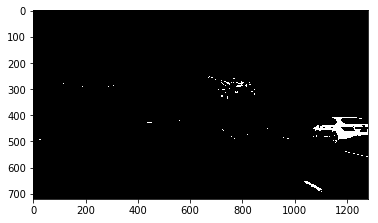

In [29]:
# Define a function that thresholds the red-channel of RGB
def red_select(img, thresh=(200, 255)):
    red_channel = img[:,:,2]  
    binary_output = np.zeros_like(red_channel)
    binary_output[(red_channel > thresh[0]) & (red_channel <= thresh[1])] = 1
    return binary_output

# test hls_select with undistorted image
red_undistorted = red_select(undistorted, (225, 255))
plt.imshow(red_undistorted, cmap='gray')

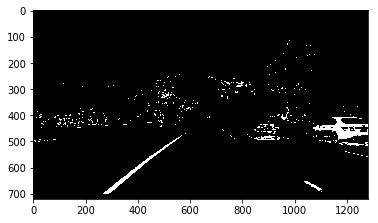

In [30]:
def thresh(img, thresh=(0,255)):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

# threshold R-channel of RGB and S-channel HLS
def colorthresh(img):
    r_channel = img[:,:,2]
    r_thresh = thresh(r_channel, thresh=(225,255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh = thresh(s_channel, thresh=(160,255))
    color_combined = np.zeros_like(s_thresh)
    color_combined[((r_thresh==1)|(s_thresh==1))] = 1
    return color_combined

# test colorthresh with undistorted image
color_combined = colorthresh(undistorted)
plt.imshow(color_combined, cmap='gray')

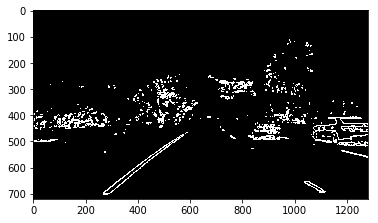

In [31]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

def mag_thresh(img, sobel_kernel=7, mag_thresh=(40, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=9, thresh=(0.65, 1.05)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def gradthresh(img):
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img)
    dir_binary = dir_threshold(img)

    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx==1)|(mag_binary == 1)) & ((grady == 1)|(mag_binary == 1))] = 1  
    return grad_combined

# test gradthresh
gradimg = gradthresh(color_combined)
plt.imshow(gradimg, cmap='gray')

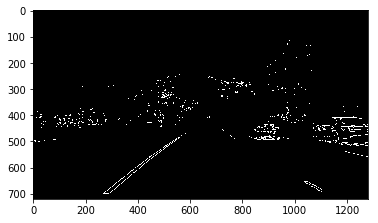

In [32]:
# combine color and grad function
def combinethresh(grad_thresh, color_thresh):
    combined_color_grad = np.zeros_like(grad_thresh)
    combined_color_grad[(grad_thresh==1) & (color_thresh==1)] = 1
    return combined_color_grad

# test combinethresh
combine_img = combinethresh(color_combined, gradimg)
plt.imshow(combine_img, cmap='gray')

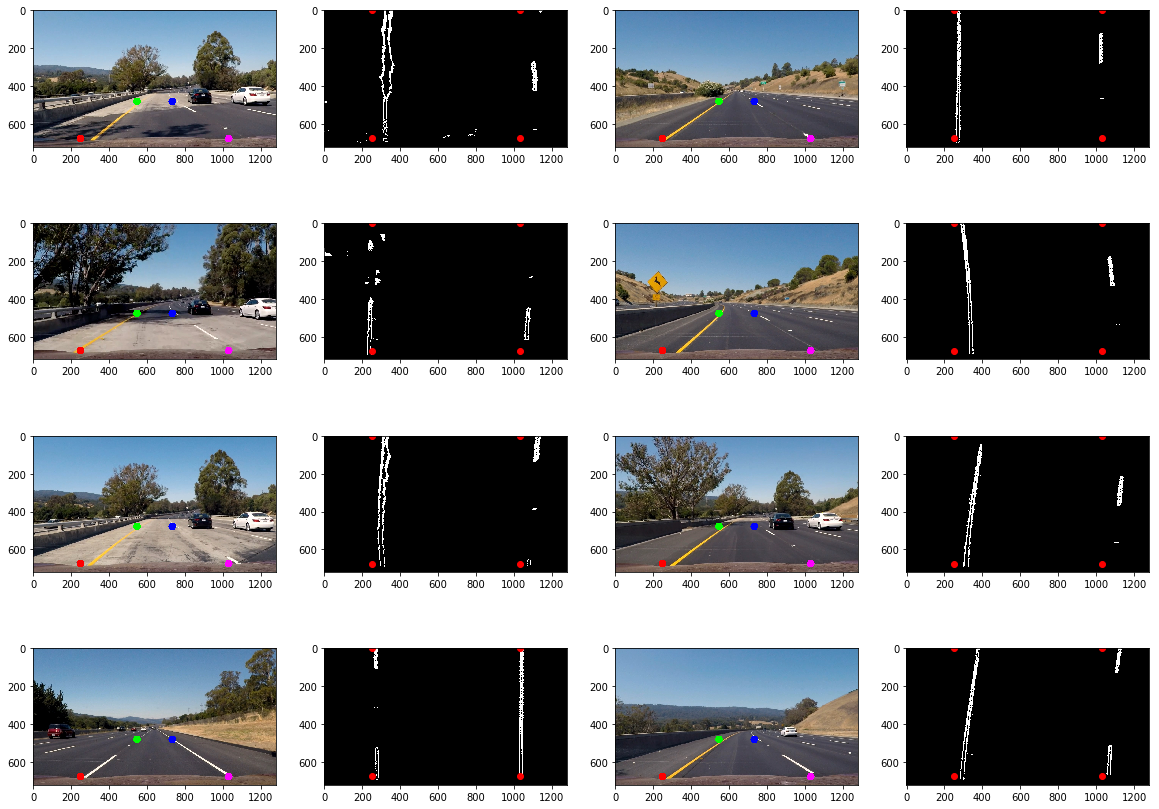

In [33]:
# For source points I'm grabbing the four corners of interested area
corners = []
corners.append([250,675])
corners.append([547,480])
corners.append([733,480])
corners.append([1030,675])
dsts = []
dsts.append(corners[0])
dsts.append([corners[0][0], 0])
dsts.append([corners[3][0], 0])
dsts.append(corners[3])
colors = []
colors.append([0,0,255])
colors.append([0,255,0])
colors.append([255,0,0])
colors.append([255,0,255])


# Define a function that takes an image, camera matrix and distortion coefficients
def corners_unwarp(img, objpoints, imgpoints):
    # Use calibration() function to remove distortion
    undistorted = calibration(img, objpoints, imgpoints)
    # Use combinethresh() function to get binary image
    color_img = colorthresh(undistorted)
    grad_img = gradthresh(color_img)
    binary_img = combinethresh(color_img, grad_img)
    
    # Grab the image shape
    img_size = (binary_img.shape[1], binary_img.shape[0])
    
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([corners[0], [corners[0][0], 0], [corners[3][0], 0], corners[3]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(binary_img, M, img_size)
                      
    # Return the resulting image and matrix
    return warped, src, dst
                      
             
# test corners_unwarp() function
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(20, 15))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    warped, src, dst = corners_unwarp(img, objpoints, imgpoints)
    fig.add_subplot(4, 4,counter)
    # plot src on original image
    for i in range(4):
        cv2.circle(img, (corners[i][0], corners[i][1]), 20, (colors[i][0],colors[i][1],colors[i][2]), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    counter += 1
    
    fig.add_subplot(4, 4,counter)
    # plot dsts on warped image
    for j in range(4):
        plt.plot([dsts[j][0]], [dsts[j][1]], 'ro')    
    plt.imshow(warped, cmap='gray') 
    counter += 1

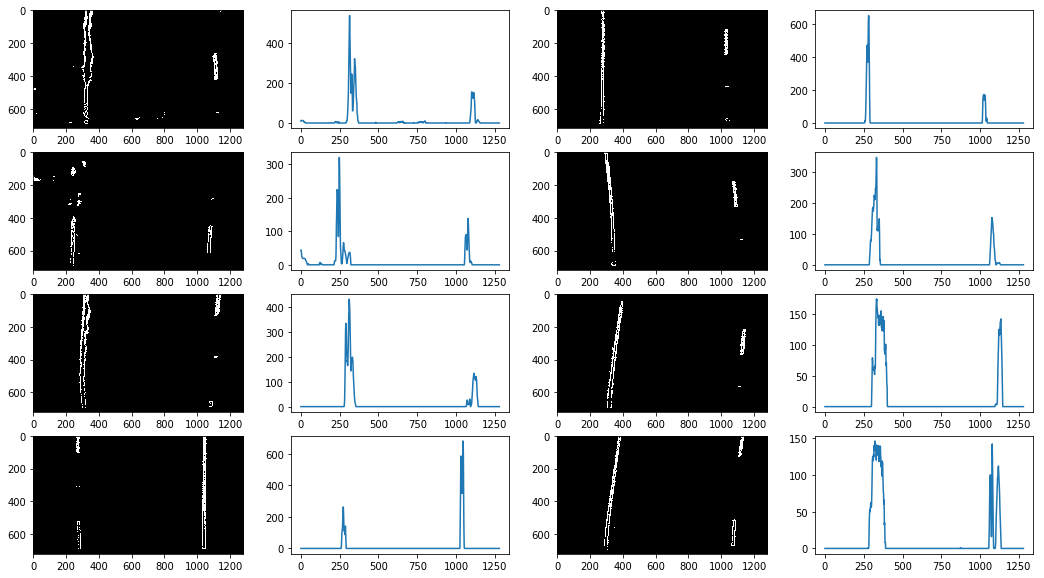

In [34]:
# plot histogram

directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(18, 10))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    warped, src, dst = corners_unwarp(img, objpoints, imgpoints)
    
    fig.add_subplot(4, 4, counter)
    plt.imshow(warped, cmap = 'gray') 
    counter += 1
    
    fig.add_subplot(4, 4,counter)
    histogram = np.sum(warped[:,:], axis=0)
    plt.plot(histogram)
    counter += 1

In [35]:
nWindows = 9 # number of sliding windows
margin = 100 # Set the width of the windows +/- margin
minpix = 50 # Set minimum number of pixels found to recenter window

def slidingWindows(img, outImg, nWindows, margin, minpix, display=False):
    # input is a binary thresholded image
    # histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
    histogram = np.sum(img, axis=0)
    # find stating points
    midpoint = np.int(histogram.shape[0]/2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint
    
    windowHeight = np.int(img.shape[0]/nWindows)
    
    # print(histogram.shape)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    # print(nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
     
    # init current network
    leftxCurrent = leftxBase
    rightxCurrent = rightxBase
    
    leftLaneInds = []
    rightLaneInds = []

    # Step through the windows one by one
    for window in range(nWindows):
        # Identify window boundaries in x and y (and right and left)
        winYlow = img.shape[0] - (window + 1) * windowHeight
        winYhigh = img.shape[0] - window * windowHeight
        
        winXleftLow = leftxCurrent - margin
        winXleftHigh = leftxCurrent + margin
        winXrightLow = rightxCurrent - margin
        winXrightHigh = rightxCurrent + margin
        
        # Draw the windows on the visualization image
        # print((winXleftLow,winYlow),(winXleftHigh,winYhigh))
        if display:
            cv2.rectangle(outImg,(winXleftLow,winYlow),(winXleftHigh,winYhigh),(1,255,1), 3) 
            cv2.rectangle(outImg,(winXrightLow,winYlow),(winXrightHigh,winYhigh),(1,255,1), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        goodLeftInds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & (nonzerox >= winXleftLow) & (nonzerox < winXleftHigh)).nonzero()[0]
        goodRightInds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & (nonzerox >= winXrightLow) & (nonzerox < winXrightHigh)).nonzero()[0]
        
        # Append these indices to the lists
        leftLaneInds.append(goodLeftInds)
        rightLaneInds.append(goodRightInds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(goodLeftInds) > minpix:
            leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
        if len(goodRightInds) > minpix:        
            rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))

    # Concatenate the arrays of indices
    leftLaneInds = np.concatenate(leftLaneInds)
    rightLaneInds = np.concatenate(rightLaneInds)

    # Extract left and right line pixel positions
    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds] 
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds] 

    # Fit a second order polynomial to each
    leftFit = np.polyfit(lefty, leftx, 2)
    rightFit = np.polyfit(righty, rightx, 2)    
    
    if display == True:
        # Generate x and y values for plotting
        fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fitLeftx = leftFit[0]*fity**2 + leftFit[1]*fity + leftFit[2]
        fitRightx = rightFit[0]*fity**2 + rightFit[1]*fity + rightFit[2]

        outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 255, 1]
        outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [1, 255, 255]
        plt.imshow(outImg)
        plt.plot(fitLeftx, fity, color='yellow')
        plt.plot(fitRightx, fity, color='yellow')
        plt.xlim(0, img.shape[1])
        plt.ylim(img.shape[0], 0)

    return outImg, leftFit, rightFit, leftx, rightx, lefty, righty

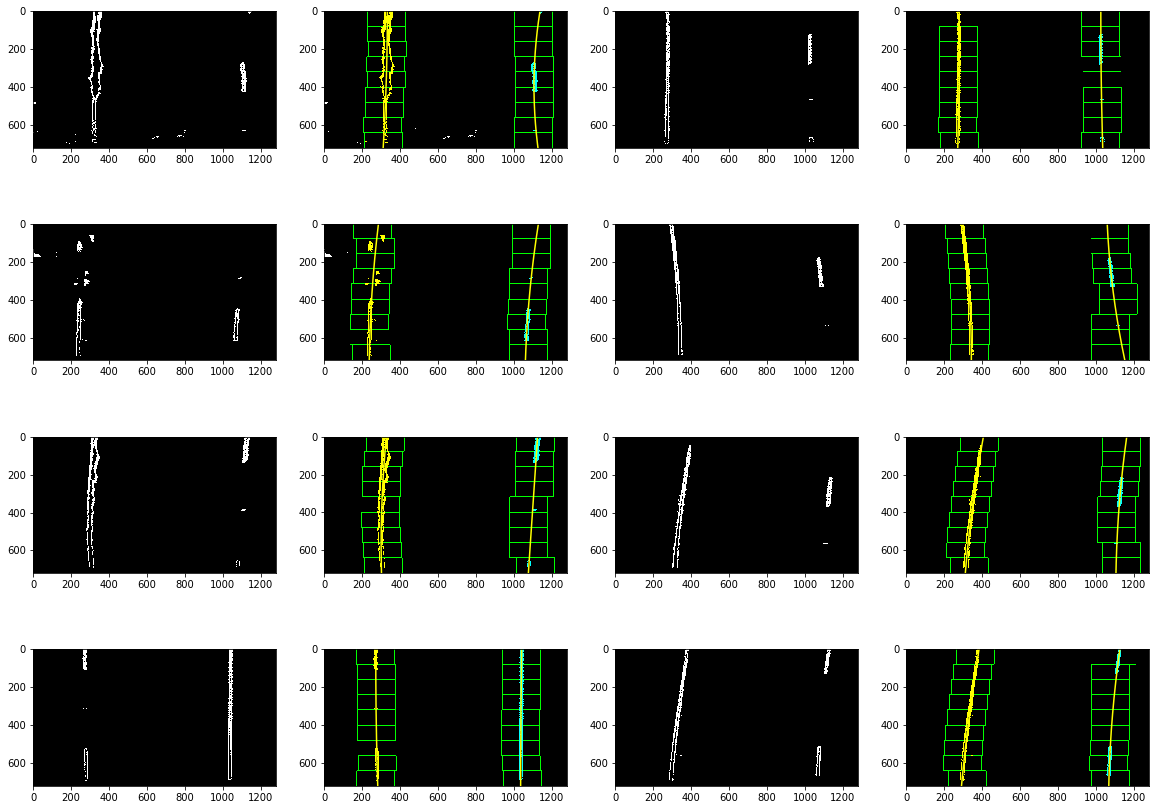

In [36]:
# test slidingWindows() function
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(20, 15))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    warped, src, dst = corners_unwarp(img, objpoints, imgpoints)
    outImg = np.dstack((warped, warped, warped))*255
    
    fig.add_subplot(4, 4,counter)
    plt.imshow(warped, cmap = 'gray') 
    counter += 1
    fig.add_subplot(4, 4,counter)
    outImg, leftFit, rightFit, leftX, rightX, leftY, rightY = slidingWindows(warped, outImg, nWindows, margin, minpix, display = True)
    counter += 1

In [37]:
def findLines(img, outImg, leftFit, rightFit, leftx, rightx, lefty, righty, margin, display=True):
    # Assume you now have a new warped binary image from the next frame of video 
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
    rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds] 
    if (nonzerox[rightLaneInds]).size != 0:
        rightx = nonzerox[rightLaneInds]
    if (nonzeroy[rightLaneInds]).size != 0:
        righty = nonzeroy[rightLaneInds]
    
    # Fit a second order polynomial to each
    try:
        leftFit = np.polyfit(lefty, leftx, 2)
    except:
        pass
    
    try:
        rightFit = np.polyfit(righty, rightx, 2)
    except:
        pass
    
    # calculate curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')

    if display == True:
        # Generate x and y values for plotting
        fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fitLeftX = leftFit[0]*fity**2 + leftFit[1]*fity + leftFit[2]
        fitRightX = rightFit[0]*fity**2 + rightFit[1]*fity + rightFit[2]
        
        windowImg = np.zeros_like(outImg)
        
        # Color in left and right line pixels
        outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 1, 1]
        outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [1, 1, 255]

        # Generate a polygon to illustrate the search window area1
        # And recast the x and y points into usable format for cv2.fillPoly()
        leftLineWindow1 = np.array([np.transpose(np.vstack([fitLeftX-margin, fity]))])
        leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([fitLeftX+margin, fity])))])
        leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
        rightLineWindow1 = np.array([np.transpose(np.vstack([fitRightX-margin, fity]))])
        rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([fitRightX+margin, fity])))])
        rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(windowImg, np.int_([leftLinePts]), (1,255, 255))
        cv2.fillPoly(windowImg, np.int_([rightLinePts]), (1,255, 255))
        result = cv2.addWeighted(outImg, 1, windowImg, 0.1, 0)
        plt.imshow(result)
        plt.plot(fitLeftX, fity, color='yellow')
        plt.plot(fitRightX, fity, color='yellow')
        plt.xlim(0, img.shape[1])
        plt.ylim(img.shape[0], 0)
        outImg = result
    
    return outImg, leftFit, rightFit, leftx, rightx, lefty, righty, left_curverad, right_curverad

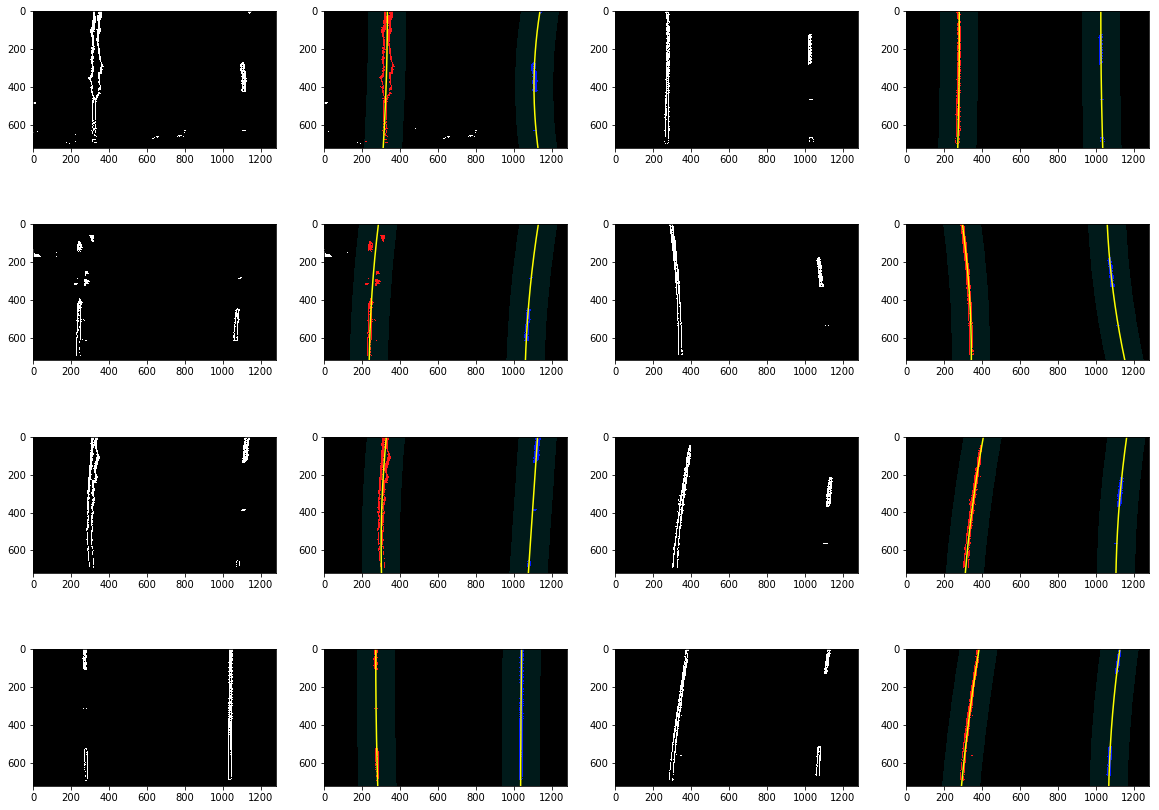

In [38]:
# test findLines() function
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(20, 15))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    warped, src, dst = corners_unwarp(img, objpoints, imgpoints)
    outImg = np.dstack((warped, warped, warped))*255
    
    fig.add_subplot(4, 4,counter)
    plt.imshow(warped, cmap = 'gray') 
    counter += 1
      
    fig.add_subplot(4, 4,counter)
    output, leftFit, rightFit, leftx, rightx, lefty, righty = slidingWindows(warped, outImg, nWindows, margin, minpix, display = False)
    outImg = np.dstack((warped, warped, warped))*255
    outImg, leftFit, rightFit, leftX, rightX, leftY, rightY, left_curverad, right_curverad= findLines(warped, outImg, leftFit, rightFit,leftx, rightx, lefty, righty, margin, display = True)
    counter += 1

In [39]:
# project back to the undistorted image
def projectBack(undist, perspectiveInvMatrix, img, leftFit, rightFit, display = False):
    # inputs: img is binary warped, image is original image and undist, inverse perspective matrix
    fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
    fitLeftX = leftFit[0]*fity**2 + leftFit[1]*fity + leftFit[2]
    fitRightx = rightFit[0]*fity**2 + rightFit[1]*fity + rightFit[2]  
    # Create an image to draw the lines on
    warpZero = np.zeros_like(img).astype(np.uint8)
    colorWarp = np.dstack((warpZero, warpZero, warpZero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsLeft = np.array([np.transpose(np.vstack([fitLeftX, fity]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([fitRightx, fity])))])
    pts = np.hstack((ptsLeft, ptsRight))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarped = cv2.warpPerspective(colorWarp, perspectiveInvMatrix, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    projBack = cv2.addWeighted(undist, 1, newwarped, 0.3, 0)
    
    if display == True:
        #plt.imshow(cv2.cvtColor(projBack,cv2.COLOR_BGR2RGB))
        plt.imshow(projBack)
        
    return projBack

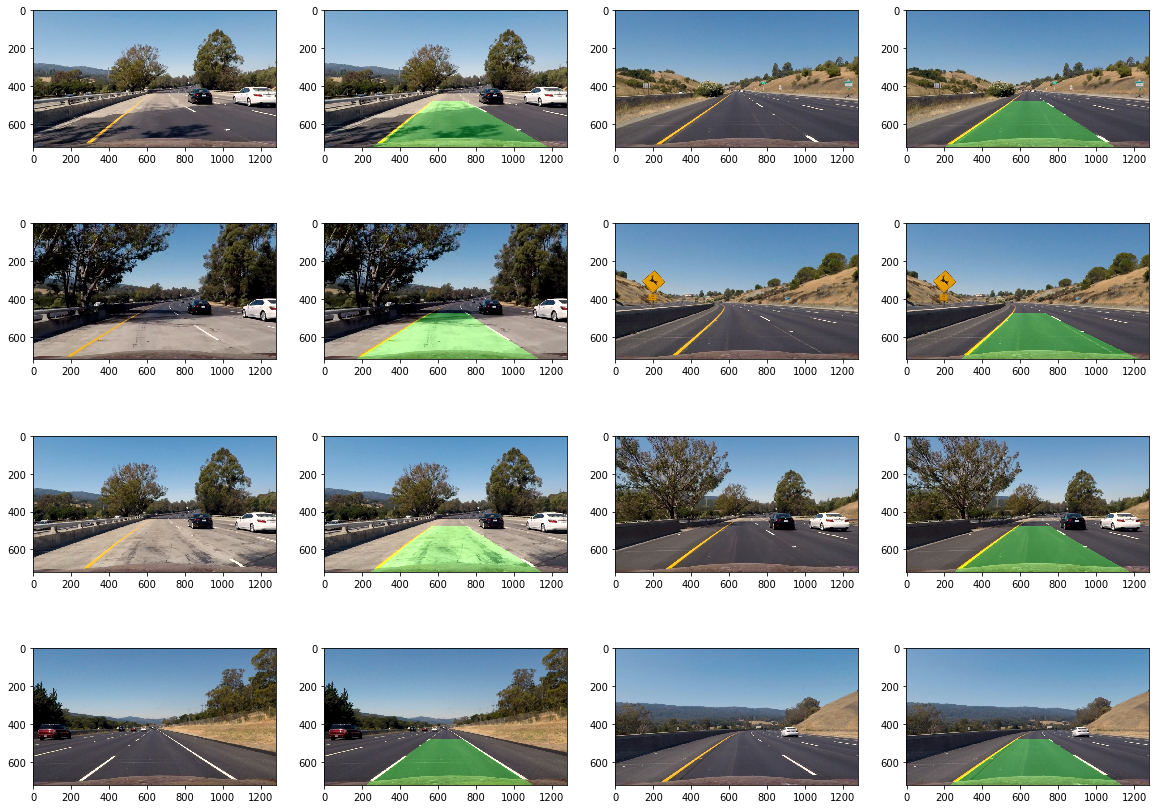

In [40]:
# test projectBack() function
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(20, 15))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    undist = calibration(img, objpoints, imgpoints)
    undist = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
    warped, src, dst = corners_unwarp(undist, objpoints, imgpoints)
    
    perspectiveMatrix = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
    perspectiveInvMatrix = np.linalg.inv(perspectiveMatrix)
        
    fig.add_subplot(4, 4,counter)
    plt.imshow(undist)
    counter += 1
    
    fig.add_subplot(4, 4,counter)
    outImg = np.dstack((warped, warped, warped))*255
    outImg, leftFit, rightFit, leftX, rightX, leftY, rightY = slidingWindows(warped, outImg, nWindows, margin, minpix, display = False)
    projBack = projectBack(undist, perspectiveInvMatrix, warped, leftFit, rightFit, display = True)
    counter += 1

In [41]:
# final pipeline
def pipeline(img):
    # calibrate img
    undist = calibration(img, objpoints, imgpoints)
    undist = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
    # unwarp calibrated image
    unwarped, src, dst = corners_unwarp(undist, objpoints, imgpoints)
    # slide windows to find lines
    outImg = np.dstack((warped, warped, warped))*255
    outImg, leftFit, rightFit, leftx, rightx, lefty, righty = slidingWindows(warped, outImg, nWindows, margin, minpix, display = False)
    # find lines
    outImg, leftFit, rightFit, leftX, rightX, leftY, rightY, left_curverad, right_curverad = findLines(unwarped, outImg, leftFit, rightFit, leftx, rightx, lefty, righty, margin, display = False)
    # calculate curvature, center and distance to the center
    curvature = (left_curverad + right_curverad) / 2
    center = (leftX[-1] + rightX[-1]) / 2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    CenterDist = (center - 640) * xm_per_pix
    if CenterDist >= 0:
        direction = 'left'
    else:
        direction = 'right'
    # backproject to calibrated image
    perspectiveMatrix = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
    perspectiveInvMatrix = np.linalg.inv(perspectiveMatrix)
    projBack = projectBack(undist, perspectiveInvMatrix, unwarped, leftFit, rightFit, display = False)
    # write figures to the projBack image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(projBack, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 2, (255, 255, 255), 3)
    cv2.putText(projBack, 'Vehicle is %.2fm %s of center' % (np.abs(CenterDist), direction), (50, 150), font, 2, (255, 255, 255), 3)
    return projBack

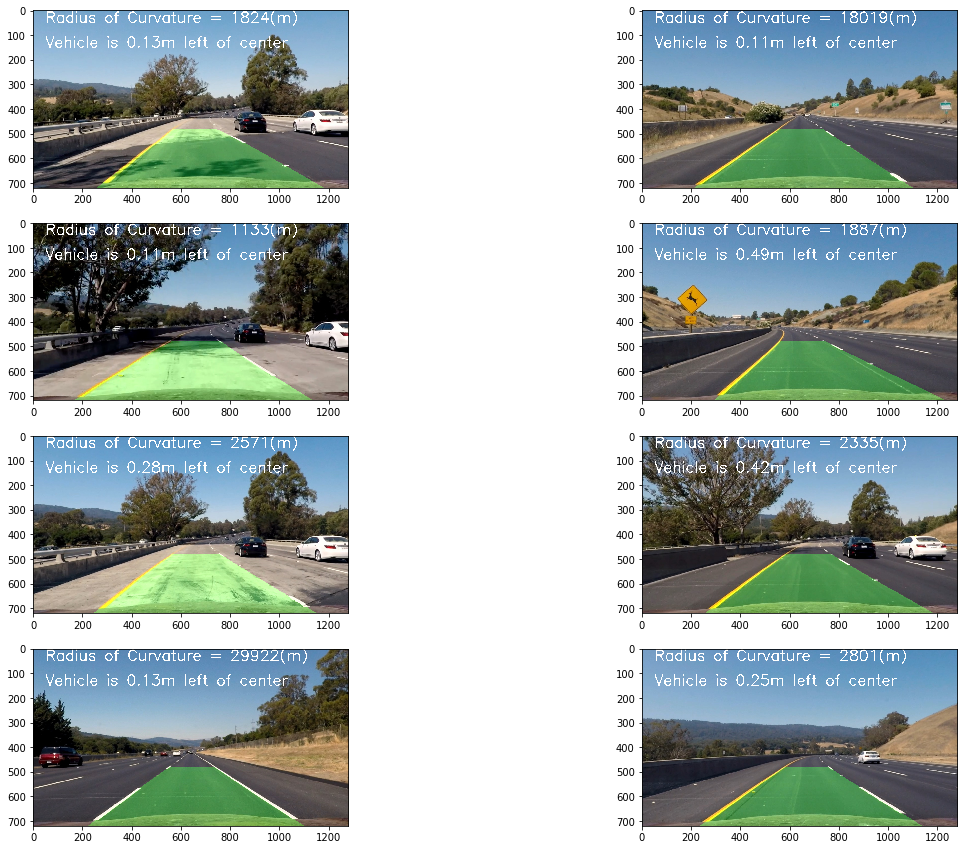

In [42]:
# test pipeline
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(20, 15))
counter = 1
for filename in globDir:
    img = cv2.imread(filename)
    result = pipeline(img)
    fig.add_subplot(4, 2,counter)
    plt.imshow(result)
    counter += 1    

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [46]:
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline).subclip(39, 43)  #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [39:20<00:01,  1.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 41min 44s, sys: 3min 7s, total: 44min 51s
Wall time: 39min 22s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))